In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from scipy.integrate import odeint, solve_ivp
"""Problem 1: Phase separation, initial value problems, and the Method of Lines"""
class AllenCahn:
    """
    An implementation of the Allen-Cahn equation in two dimensions, using the method
    of lines and explicit finite differences

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        kappa (float): reaction rate
        d (float): diffusion coefficient
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction

    """

    def __init__(self, nx, ny, kappa=1.0, d=1.0, Lx=1.0, Ly=1.0):
        self.nx = nx
        self.ny = ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.d = d
        self.kappa = kappa
       
    def _laplace(self, grid):
        """
        Apply the two-dimensional Laplace operator to a square array
        """
       
        #Define boundary conditions for rows in input grid
        grid = np.vstack([grid[0,:][None,:],grid,grid[-1,:][None,:]])
        #Define boundary conditions for columns in input grid
        grid = np.hstack([grid[:,0][:,None], grid, grid[:,-1][:,None]])

        #Intialize grid for speed
        changed_grid = np.zeros((self.ny,self.nx))

        #Vectorize the grid element addition p(j+1,i) -> grid[1:-2,1:-1]
        changed_grid = grid[:-2,1:-1]+grid[1:-1,:-2]+grid[2:,1:-1]+grid[1:-1,2:] 
        changed_grid -= 4*grid[1:-1,1:-1]

        changed_grid /= self.dx*self.dy

        return changed_grid

    def _reaction(self, y):
        """
        Bistable reaction term
        """
        return y*(1-y**2)

    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        y = y.reshape((self.ny,self.nx))
        eq = self.d*self._laplace(y)+self.kappa*self._reaction(y)
        return eq.flatten()


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the odeint solver
        **kwargs are passed to scipy.integrate.solve_ivp
        """

        time = np.linspace(t_min,t_max,nt)
        s_ret = solve_ivp(self.rhs,(t_min, t_max),y0.flatten(),t_eval=time,**kwargs)
        sln = s_ret.y.T
        time = s_ret.t
        
        return time, sln.reshape((len(time), self.ny, self.nx))

In [ ]:
np.random.seed(0)
ic = np.random.random((40, 40))-.6
model = AllenCahn(*ic.shape, kappa=1e1, d=0)
tpts, sol = model.solve(ic, 0, 8, 300, method="DOP853")


plt.figure()
plt.imshow(sol[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol[-1], vmin=-1, vmax=1)

In [ ]:
"""Varying D and kappa"""
"""2. The effect of increasing kappa is the same as decreasing D and vice versa. As D decreases, the domain sizes become smaller as the values tend to diffuse less and less from the intial condition. As kappa decreases, the two fluids are conversely more likely to mix with each other and form large domains. In the limit that kappa goes to zero, there would be a single large domain corresponding to the heat equation which does match that special case solution. If D goes to zero, then the solution should lose its tendency to diffuse spatially and be reliant on time alone, but contrary to my intuition, the solution stayed the same even at large time scales."""

In [ ]:
"""Mesh size, timestep, duration"""
"""3. At a mesh size of 400 x 400, the solver appears to fail by simply not producing a solution at all. The timer ran on for several minutes without finishing. When increasing the size of the integration time step, the solver is actually incredibly robust, still producing an accurate result from nt = 2 and only failing at nt = 1 with the failure simply looking exactly like the initial condition. Decreasing the integration duration produces a fairly accurate result even down to t_max = 2, but by t_max = 0.4, the result is nearly unrecognizable. Failure in this case is a washed out mesh with no recognizable patterns. """

In [ ]:
"""Gaussian blur"""
"""4. The heat equation tends to smooth out sharp differences in adjacent cells. In a photo, this would be analogous to "blurring" or smearing the lines. Taking D=0 takes each initial value and pushes it to the far end of its spectrum which makes it seem like increasing the contrast in photo-editing, but at already fairly uniform distributions, it simply eliminates all differences, which seems more like saturation. If I had to choose one of the two, though, I would lean more towards Contrast"""

In [27]:
"""Problem 2: Turing's model of morphogenesis and spectral methods"""

from scipy.integrate import solve_ivp

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u

    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.01, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

        
    def _reaction(self, y):
        """
        Compute the reaction term in real space
        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]
        uvsq = u*(v**2)

        u_reac = self.b*(1-u)
        u_reac_full = -uvsq + u_reac

        v_reac = self.kappa*v
        v_reac_full = uvsq - v_reac
        y_reac = np.hstack([u_reac_full,v_reac_full])
        return y_reac

    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
        #Change flattened y back into an array for Fourier transforms
        y = np.reshape(y,(self.nx, self.ny))
        ft = np.fft.fft2(y)
        ift = np.fft.ifft2(-self.ksq*ft)
        #Re-flatten array
        return np.real(ift).flatten()

    def _diffusion(self, y):
        
        """Calculate the diffusion term in Fourier spaceArgs:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        #Pull out the individual fields from the stacked array
        u, v = y[:(self.ny*self.nx)],y[-(self.ny*self.nx):]
        u_lap = self._laplace(u)
        v_lap = self._laplace(v)
        #Multiply each field by diffusion coefficient
        u_diff = self.du * u_lap
        v_diff = self.dv * v_lap
        #Restack fields into a single array
        y_diff = np.hstack([u_diff,v_diff])
        return y_diff

    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        uv_eq = self._reaction(y)+self._diffusion(y)
        return uv_eq
    
    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver

        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp

        """
        u0, v0 = y0
        time = np.linspace(t_min,t_max,nt)
        y0 = np.hstack([u0.flatten(), v0.flatten()])
        sol = solve_ivp(self.rhs,(t_min,t_max), y0, t_eval=time, **kwargs)
        sol_trans = sol.y.T

        u, v = sol_trans[:,:(self.nx*self.ny)],sol_trans[:,(self.nx * self.ny):]
        u = np.reshape(u, (nt, self.ny, self.nx))
        v = np.reshape(v,(nt, self.ny, self.nx))
        return time, np.stack([u,v], axis=-1)
        

In [59]:
import numpy as np
from scipy.integrate import solve_ivp


def make_initial_conditions(n):
    """
    Make a bump-shaped initial conditions array
    """
    xx, yy = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
    rr =  (xx**2 + yy**2)**0.5
    u_ic = 1 - 0.5 * np.copy(np.exp(-rr**2 - xx**2))
    v_ic = 0.25 * np.copy(np.exp(-rr**2))
    return u_ic, v_ic

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model
    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u
    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

        
    def _reaction(self, y):
        """
        Compute the reaction term in real space
        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        ########################################################################
        #
        # Your code here. If you are performing the reaction in real space, this is
        # relatively straightforward. If you are performing the reaction in Fourier
        # space, you will need to perform an inverse Fourier transform
        #
        ########################################################################
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]
        uv2 = u * (v**2)
        rxn_u = -uv2 + self.b * (1 - u)
        rxn_v = uv2 - self.kappa * v
        y_out = np.hstack([rxn_u, rxn_v])
        return y_out

    # ## Finite difference approach
    # def _laplace(self, y):
    #     """
    #     Calculate the Laplacian in real space of a flat array

    #     Args:
    #         y (np.ndarray): array of shape (nx * ny, ) containing the a single field
    #     """
    #     y = np.reshape(y, (self.nx, self.ny))
    #     lap = np.zeros((self.ny, self.nx))
    #     # enforce reflection boundary conditions by padding rows and columns
    #     y = np.vstack([y[-1, :][None, :], y, y[0, :][None, :]])
    #     y = np.hstack([y[:, -1][:, None], y, y[:, 0][:, None]])

    #     # calculate vectorized laplace operator
    #     lap = y[:-2, 1:-1] + y[1:-1, :-2] + y[2:, 1:-1] + y[1:-1, 2:]
    #     lap  -= 4 * y[1:-1, 1:-1]
        
    #     #lap /= self.dx * self.dy
    #     return lap.flatten()


    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
         ########################################################################
        #
        # Your code here.
        #
        ########################################################################
        y = np.reshape(y, (self.nx, self.ny))
        yk = np.fft.fft2(y)
        lap = -self.ksq * yk
        lap = np.fft.ifft2(lap)
        return np.real(lap).flatten()


    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space
        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        ########################################################################
        #
        # Your code here. I split the Laplace operator into its own function
        #
        ########################################################################
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]
        lap_u = self._laplace(u)
        lap_v = self._laplace(v)
        u_out = self.du * lap_u
        v_out = self.dv * lap_v
        y_out = np.hstack([u_out, v_out])
        return y_out



    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        ########################################################################
        #
        # Your code here. This mainly calls other functions, in my implementation
        #
        ########################################################################
        out = self._reaction(y) + self._diffusion(y)
        return out


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver
        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp
        """
        ########################################################################
        #
        # Your code here. I recommend using the solve_ivp solver, along with judicious
        # use of np.reshape operation and np.hstack, because solve_ivp expects a
        # one-dimensional vector as input
        #
        ########################################################################
        u0, v0 = y0
        tpts = np.linspace(t_min, t_max, nt)
        y0 = np.hstack([u0.flatten(), v0.flatten()])
        out = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=tpts, **kwargs)
        sol = out.y.T
        
        u, v = sol[:, :self.nx * self.ny], sol[:, self.nx * self.ny:]
        u = np.reshape(u, (nt, self.ny, self.nx))
        v = np.reshape(v, (nt, self.ny, self.nx))
        return tpts, np.stack([u, v], axis=-1)


Imaginary residual is: 0.0


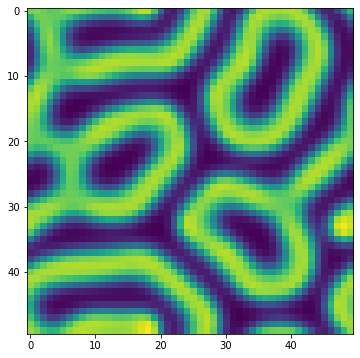

In [70]:
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((50, 50))
v_ic = 1 - np.copy(u_ic)

## Run simulation
model = GrayScott(*u_ic.shape)
time, sol = model.solve([u_ic, v_ic], 0, 5000, nt=1000)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

In [45]:
"""Varying D and b"""
"""2. Increasing Dv and b has the same effect on the resulting scalar field, namely, the field reaches a maximal state of disorder where each mesh point alternates values. This same disrdered state occurs when you decrease Du. Conversely, changing those parameters in the opposite manner generally leads to formation of small circular islands (although the density and size of these islands) varies. At the largest values of Du, the islands are several mesh points wide and fairly dense in contrast to small values of Dv where the islands are still dense but only one mesh point across. Large values of b lead to large islands that are sparsely distributed. Since b is the rate of reaction of u, increasing it seems like it would lead to a higher concentration of v while decreasing it would prevent u from changing into v, which does seem to be the case. When b is small, there are very large sections of both u and v which remain constant. The result from increasing Du would be intuitive if the dark purple color corresponded to u. In that case, it would be easy for u to spread out around the v particles which would tend to clump together. Decreasing Dv would have a similar effect because the v particles would tend to move less relative to the u particles."""

'2. Increasing Dv and b has the same effect on the resulting scalar field, namely, the field reaches a maximal state of disorder where each mesh point alternates values. This same disrdered state occurs when you decrease Du. Conversely, changing those parameters in the opposite manner generally leads to formation of small circular islands (although the density and size of these islands) varies. At the largest values of Du, the islands are several mesh points wide and fairly dense in contrast to small values of Dv where the islands are still dense but only one mesh point across. Large values of b lead to large islands that are sparsely distributed. Since b is the rate of reaction of u, increasing it seems like it would lead to a higher concentration of v while decreasing it would prevent u from changing into v, which does seem to be the case. When b is small, there are very large sections of both u and v which remain constant. The result from increasing Du would be intuitive if the dark

In [71]:
"""Fourier"""
"""3. Fast Fourier Transforms scale as O(NlogN) which is better than the previous O(N^2) for normal Fourier Transforms, but when N is 10000, even that is still large. Computing the discrete Laplacian has scaling of O(N) which is slightly but not much cheaper than the FFT. For FFT to be comparable N would have to be 3 or less."""


'3. Fast Fourier Transforms scale as O(NlogN) which is better than the previous O(N^2) for normal Fourier Transforms, but when N is 10000, even that is still large. Computing the discrete Laplacian has scaling of O(N) which is slightly but not much cheaper than the FFT. For FFT to be comparable N would have to be 3 or less.'

In [72]:
"""Varying timesteps and spacepoints"""
"""4. Decreasing the number of time points: I didn't see a noticable effect even decreasing the number of steps down to 10. When I finally reach a single time step, the solution failed by becoming maximally chaotic with no obvious steady state solution. Decreasing the number of mesh grid points changed the field, but it didn't fail until the single digits, at which point, the field took on a single uniform value. This failure was similar to the previous equation. Increasing the number of points didn't cause the solver to fail, but it did take a very long time. """

"4. Decreasing the number of time points: I didn't see a noticable effect even decreasing the number of steps down to 10. When I finally reach a single time step, the solution failed by becoming maximally chaotic with no obvious steady state solution. Decreasing the number of mesh grid points changed the field, but it didn't fail until the single digits, at which point, the field took on a single uniform value. This failure was similar to the previous equation. Increasing the number of points didn't cause the solver to fail, but it did take a very long time. "

In [58]:
"""Evolution"""
"""5. Evolutionary forces would tend to act on the parameter which most strongly affects change as that parameter would be most likely to introduce variation and thus diversity into a population. Du, Dv, and b all affected the field somehow, but if we're only looking at spacing of the islands, Du and b tended to affect that outcome the most (with Du having a slight edge)."""

"5. Evolutionary forces would tend to act on the parameter which most strongly affects change as that parameter would be most likely to introduce variation and thus diversity into a population. Du, Dv, and b all affected the field somehow, but if we're only looking at spacing of the islands, Du and b tended to affect that outcome the most (with Du having a slight edge)."

In [62]:
"""Boundary Conditions"""
"""6. The effect of the periodic boundary conditions is that the left and right sides and the top and bottom sides are effectively connected, which you can see if you look closely at the figures. If this was instead changed to the mirror boundary from before (no flux), the edges would no longer be continuous. The long term modes would certainly be different then and might not even form."""

'6. The effect of the periodic boundary conditions is that the left and right sides and the top and bottom sides are effectively connected, which you can see if you look closely at the figures. If this was instead changed to the mirror boundary from before (no flux), the edges would no longer be continuous. The long term modes would certainly be different then and might not even form.'